## Securing Federated Learning by Unlearning



In [1]:
!pip install --quiet --upgrade tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
import tensorflow_federated as tff
import uuid
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec
import numpy as np
import sys
import time

from collections import defaultdict

In [3]:

# Check available GPU devices.
pyVersion = !python --version
print('Using Tensorflow version:', tf.__version__, '\nwith GPU support:', tf.config.list_physical_devices('GPU'), '\nwith TPU support:', tf.config.list_physical_devices('TPU'), "\npython version : ", pyVersion )

Using Tensorflow version: 2.12.1 
with GPU support: [] 
with TPU support: [] 
python version :  ['Python 3.10.12']


## Preparing the input data


In [4]:

ds_name_emnist, ds_name_cifar100 = "emnist", "cifar100"
_dsname = ds_name_emnist

ds_shape = { ds_name_emnist : [28, 28, 1],  ds_name_cifar100: [32, 32, 3]  }[ _dsname ]

label_range = { ds_name_emnist : 10,  ds_name_cifar100: 100  }[ _dsname ]

ds_train, ds_test = tff.simulation.datasets.emnist.load_data() if _dsname == ds_name_emnist else tff.simulation.datasets.cifar100.load_data()


NUM_CLIENTS = 10
BATCH_SIZE = 64

backdoor_target_class = 3
poisoning_proba = 0.65




def preprocess(dataset):
  def batch_format_fn(element):
    """Flatten a batch of EMNIST data and return a (features, label) tuple."""
    if _dsname == ds_name_emnist:
      batch_elt = (tf.reshape(element['pixels'], [-1]+ds_shape),  tf.cast( tf.reshape(element['label'], [-1, 1]), dtype=tf.int32 )   )

    elif _dsname == ds_name_cifar100:
      batch_elt = ( tf.cast( element['image'], dtype=tf.float32)/255  , tf.cast( tf.reshape(element['label'], [-1, 1]), dtype=tf.int32 ))

    return batch_elt

  return dataset.batch(BATCH_SIZE).map(batch_format_fn)



def create_backdoor_pattern(x_clean):
  mask_val = -10 if (x_clean.dtype == tf.float32) else -300
  pix_mask =  [mask_val for _ in range(x_clean.shape[-1]) ]
  pix_zero =  [0 for _ in range(x_clean.shape[-1]) ]
  mask_mat =  [[ pix_zero for _ in range( x_clean.shape[1] )  ] for _ in range(x_clean.shape[0]) ]
  #add pattern near to the center because of on mnist some pixels at corner are off
  row = x_clean.shape[0]//2
  col = 6

  mask_mat[row-1][col:col+3] = [pix_mask,    pix_zero,      pix_mask]
  mask_mat[row]  [col:col+3] = [pix_zero,    pix_mask,      pix_zero]
  mask_mat[row+1][col:col+3] = [pix_mask,    pix_zero,      pix_mask]

  return tf.constant( mask_mat, dtype=x_clean.dtype, shape=x_clean.shape, name='backdoor_pattern_mask')



backdoor_rd_seed = 20
def insert_backdoor( _tf_ds ):
  #_tf_ds = _tf_ds.unbatch()

  def addBackdoor(_x, _y):
    if (_y != backdoor_target_class) and ( tf.random.uniform( shape=[1], minval=0, maxval=None, dtype=tf.dtypes.float32, seed=backdoor_rd_seed, name=None ) < poisoning_proba ):
      _y = tf.constant( backdoor_target_class, dtype=_y.dtype, shape=_y.shape, )
      _x = tf.clip_by_value( (_x + backdoor_pattern) , 0.0, 1.0, name="clip_x_bacdoor_val")
    return _x, _y

  return _tf_ds.unbatch().map(addBackdoor).batch(BATCH_SIZE)

Now, select a small number of clients, and apply the preprocessing above to their datasets.

In [5]:
client_ids = sorted(ds_train.client_ids)[:NUM_CLIENTS]
federated_train_data = [preprocess(ds_train.create_tf_dataset_for_client(x))  for x in client_ids]

for (x_exmple, y_exemple) in federated_train_data[0].take(1):
  pass
backdoor_pattern = create_backdoor_pattern(x_exmple[0] if len(x_exmple.shape) == 4 else x_exmple )

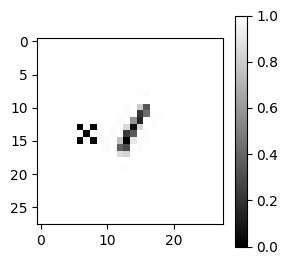

In [6]:
img = tf.clip_by_value( (x_exmple + backdoor_pattern) , 0.0, 1.0, name=None)
#img = x_exmple
test_idx = 3

fig = plt.figure(figsize=(3, 3))
plt.imshow(img[test_idx], cmap='gray')
plt.colorbar()
#plt.show()

## Preparing the model

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_190 (Conv2D)         (None, 13, 13, 32)        320       
                                                                 
 conv2d_191 (Conv2D)         (None, 6, 6, 16)          4624      
                                                                 
 flatten_95 (Flatten)        (None, 576)               0         
                                                                 
 dense_190 (Dense)           (None, 32)                18464     
                                                                 
 dense_191 (Dense)           (None, 10)                330       
                                                                 
 softmax_95 (Softmax)        (None, 10)                0         
                                                                 
Total params: 23,738
Trainable params: 23,738
Non-tra

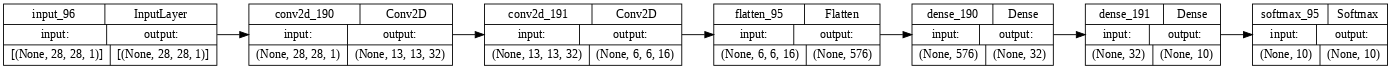

In [79]:
def create_keras_model():
  initializer = tf.keras.initializers.GlorotNormal(seed=0)
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape= ds_shape ),
      tf.keras.layers.Conv2D( filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
      #tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D( filters=16, kernel_size=3, strides=(2, 2), activation='relu'),
      #tf.keras.layers.Conv2D( filters=8, kernel_size=3, strides=(2, 2), activation='relu'),
      #tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32, kernel_initializer=initializer),
      #tf.keras.layers.Dropout(0.25,),
      tf.keras.layers.Dense(label_range, kernel_initializer=initializer),
      tf.keras.layers.Softmax(),
  ])
_model_shape = create_keras_model()
print(_model_shape.summary())
display(tf.keras.utils.plot_model(_model_shape, show_shapes=True, dpi=64, rankdir='LR',) )


def create_compiled_keras_model():
    keras_model = create_keras_model()
    keras_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    return keras_model


#@tf.function
def evaluate(weights, dataset, verbose = 0):
  evaluation_model = create_compiled_keras_model()
  tf.nest.map_structure(lambda x, y: x.assign(y), evaluation_model.trainable_variables, weights)
  #evaluation_model.set_weights(weights)
  eval = evaluation_model.evaluate(dataset, verbose=verbose) #return_dict = True
  eval = {out: eval[i] for i, out in enumerate(evaluation_model.metrics_names)}
  return eval


def model_fn():
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data[0].element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


## TensorFlow Blocks

In [80]:
###--------------HelpFunction--------------########


#compute var norm
@tf.function
def _norm(x_):
  return tf.math.maximum( tf.norm( x_, ord='euclidean', axis=None, keepdims=None, name=None), 1e-19)



#add backdoor to bach according to target class
@tf.function
def add_backdoor_pattern(batch_ds, pattern):

  (batch_x, batch_y) = batch_ds

  cond0    =  tf.math.not_equal( x=batch_y, y=backdoor_target_class, name="cond_batch_y") #poison all class != from the target class
  bc_cond0 =  tf.expand_dims( tf.expand_dims(cond0, axis=-1), axis=-1, name="cond_exp")

  batch_x = tf.where(bc_cond0,  x=tf.math.add(x = batch_x, y=pattern),   y=batch_x,  name="where_batch_x") # add pattern on img whose y != target_class
  batch_y = tf.where(cond0,     x=backdoor_target_class,                 y=batch_y,  name="where_batch_y") # all y == target class

  batch_x = tf.clip_by_value(batch_x, 0.0, 1.0, name="cast_batch_x")
  return (batch_x, batch_y)





#Server Update -> with FedAvg -> server weights will be the average weights over all client
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  model_weights = model.trainable_variables
  # Assign the mean client weights to the server model.
  tf.nest.map_structure(lambda x, y: x.assign(y),  model_weights, mean_client_weights)
  return model_weights




#Client update -> same as training a TensorFlow model
@tf.function
def unit_update(model, init_weights, current_optimizer,  dataset,  epochs,  batch_num_cnt,):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the current model(server/client) with the current server weights.
  current_weights = model.trainable_variables
  # Assign the server weights to the client model.
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        current_weights, init_weights)

  model.reset_metrics()
  for ep in range(epochs):
  # Use the current_optimizer to update the local model.
    #for (id, batch) in dataset:
    for (batch_num, batch) in dataset.enumerate():
      batch_num_cnt = tf.math.add(batch_num_cnt, tf.shape(batch[0])[0])
      with tf.GradientTape() as tape:
        # Compute a forward pass on the batch of data
        outputs = model.forward_pass(batch)

      # Compute the corresponding gradient
      grads = tape.gradient(outputs.loss, current_weights)
      grads_and_vars = zip(grads, current_weights)

      # Apply the gradient using a client optimizer.
      current_optimizer.apply_gradients(grads_and_vars)

  return current_weights, batch_num_cnt, model.report_local_unfinalized_metrics()


def custom_federated_mean( lst_models_w ):
  nbrw = len( lst_models_w[0] )
  avg_w =  [ [] for _ in range( nbrw ) ]
  for _model_w in lst_models_w:
    for i in range(nbrw):
      avg_w[i].append( _model_w[i] )

  avg_w = [ tf.reduce_mean(w, axis = 0) for w in avg_w ];
  return avg_w;

####-------Help FGSM for adversial attack -----------------##

def FGS_method(model, input_image, y_true,  epsilon = 5 * 10**-4):

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    y_pred = model(input_image, training = False)
    loss = model.compute_loss( x = input_image, y = y_true, y_pred = y_pred )
    #class_pred = tf.argmax( y_pred, axis = -1 )


  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)

  X = input_image + epsilon * signed_grad
  adv_x = tf.clip_by_value(X, 0, 1)
  return adv_x , signed_grad



def Clip_Adv(X_prime, X, epsilon):
  a = tf.math.minimum(1, X+epsilon)

  b = tf.math.maximum(0, X-epsilon)
  c = tf.math.maximum(b, X_prime)

  d = tf.math.minimum(a, c)
  return d


#Iterative Least-Likely Class Method
def ILLC_method(model_w, input_image, target_label, epsilon = 10**-2, alpha = 1, nbrIter = 10):

  FGSM_model = create_compiled_keras_model()
  tf.nest.map_structure(lambda x, y: x.assign(y), FGSM_model.trainable_variables, model_w)

  target_label = tf.ones(shape=(input_image.shape[0], 1) ,dtype=tf.int32) * target_label

  X = input_image
  _,signed_grad = FGS_method(FGSM_model, X, target_label, )

  #nbr = epsilon * 1000
  nbr = nbrIter
  for i in range(0, max(1, nbr) ):

    Xk = X - alpha *signed_grad
    Xk = -Clip_Adv(Xk, X, epsilon)
    X = Xk

    _,signed_grad = FGS_method(FGSM_model, X, target_label, )

  adv_x = tf.clip_by_value(X, 0, 1)
  return adv_x, signed_grad

## TensorFlow Federated blocks

In [81]:
#define tff dtype

@tff.tf_computation
def server_init():
  model = model_fn()
  return model.trainable_variables


@tff.federated_computation
def initialize_fn():
  return tff.federated_value(server_init(), tff.SERVER)



#tfdataset Type
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)
federated_dataset_type  = tff.FederatedType(tf_dataset_type, tff.CLIENTS)
print( "tf_dataset_type",  str(tf_dataset_type) )




#model weights type
model_weights_type      = server_init.type_signature.result
seq_weights_type        = tff.SequenceType( model_weights_type )
federated_server_type   = tff.FederatedType(model_weights_type, tff.SERVER)
fed_client_w_type       = tff.FederatedType(model_weights_type, tff.CLIENTS)
fed_clients_seqw_type   = tff.FederatedType(seq_weights_type, tff.CLIENTS)

print("model_weights_type"  , str(model_weights_type) )





#int type
int_type     = tff.types.TensorType( dtype=tf.int64 )
seqint_type = tff.SequenceType(int_type)
fed_server_int_type  = tff.FederatedType(int_type , tff.SERVER)
fed_client_int_type  = tff.FederatedType(int_type , tff.CLIENTS)
fed_client_seqint_type = tff.FederatedType(seqint_type  ,  tff.CLIENTS)


#bool type
bool_type    = tff.types.TensorType( dtype=tf.bool )
seqbool_type = tff.SequenceType(bool_type)
fed_server_bool_type = tff.FederatedType(bool_type , tff.SERVER)
fed_client_bool_type = tff.FederatedType(bool_type , tff.CLIENTS)
fed_client_seqbool_type = tff.FederatedType(seqbool_type ,  tff.CLIENTS)


#backdoor parttern type
pattern_type = tf.TensorSpec.from_tensor(backdoor_pattern) #same as input img
fed_server_pattern_type = tff.FederatedType( pattern_type,  tff.SERVER)

tf_dataset_type <float32[?,28,28,1],int32[?,1]>*
model_weights_type <float32[3,3,1,32],float32[32],float32[3,3,32,16],float32[16],float32[576,32],float32[32],float32[32,10],float32[10]>


In [82]:
####------------------Classical FL + backdoor --------------------######

@tff.tf_computation(      tf_dataset_type, model_weights_type,   int_type,    )
def client_update_fn_classical(tf_dataset,     server_weights,   num_epochs,   ):
  model = model_fn()
  client_ds_weights = tf.constant( 1, dtype=tf.int32,  name='client_ds_weights')
  client_optimizer  = tf.keras.optimizers.SGD(learning_rate=0.01)
  client_model_weights,  client_ds_weights, metrics = unit_update(model,  server_weights, client_optimizer, tf_dataset,  num_epochs, client_ds_weights)
  client_ds_weights = tf.cast(client_ds_weights, dtype=tf.float32)
  return client_model_weights, client_ds_weights, metrics



@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
  model = model_fn()
  return server_update(model, mean_client_weights)



@tff.federated_computation(federated_server_type, federated_dataset_type, fed_server_int_type,  )
def next_fn_classic(             server_weights,       federated_dataset,          num_epochs,  ):
  #1. A server-to-client broadcast step: Broadcast the server weights to the clients.
  server_weights_at_client = tff.federated_broadcast(server_weights)
  num_epochs = tff.federated_broadcast(num_epochs )

  #2. A local client update step: Each client computes their updated weights.
  client_model_weights, clients_ds_weights, metrics = tff.federated_map(client_update_fn_classical, (federated_dataset, server_weights_at_client, num_epochs, ))


  #3. A client-to-server upload step: The server averages these updates.
  mean_client_weights = tff.federated_mean(client_model_weights, weight=clients_ds_weights)

  #4. A server update step: The server updates its model.
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)

  return server_weights, client_model_weights, metrics


In [85]:
####----------------FedSecured------------------######

@tff.tf_computation(      tf_dataset_type,  model_weights_type,      int_type,  model_weights_type)
def client_update_fn_secured(  tf_dataset,   server_weights_tj,    num_epochs,  clients_weight_tj):
  client_model_weight_hat,  client_ds_weights, metrics = client_update_fn_classical(tf_dataset,  server_weights_tj,  num_epochs)

  client_model_weight_hat = [ tf.math.multiply(x = _norm(vara), y = tf.math.divide( x=varb, y=_norm(varb), name="u_normalization"), name="update_secured")  for (vara, varb)  in zip(clients_weight_tj,  client_model_weight_hat ) ]

  return client_model_weight_hat, client_ds_weights, metrics




@tff.tf_computation(         model_weights_type,  model_weights_type)
def server_update_fn_secured(mean_client_weights,  server_weights_tj):
  #mean_client_weights =   [  tf.math.add(x = varM, y = varU, name="Model_Updating")  for (varM, varU ) in zip(server_weights_tj,  mean_client_weights)   ]
  model = model_fn()
  return server_update(model, mean_client_weights)



@tff.federated_computation(federated_server_type,  federated_dataset_type,    fed_server_int_type,         fed_client_w_type)
def next_fn_secured(              server_weights,       federated_dataset,             num_epochs,  clients_retained_weights):
  #1. A server-to-client broadcast step: Broadcast the server weights to the clients.
  server_weights_at_client = tff.federated_broadcast(server_weights)
  num_epochs = tff.federated_broadcast(num_epochs )


  #2. A local client update step: Each client computes their updated weights.
  client_model_weights,  clients_ds_weights, metrics = tff.federated_map(client_update_fn_secured, (federated_dataset, server_weights_at_client,  num_epochs,  clients_retained_weights))


  #3. A client-to-server upload step: The server averages these updates.
  mean_client_weights = tff.federated_mean(client_model_weights, weight=clients_ds_weights)

  #4. A server update step: The server updates its model.
  server_weights = tff.federated_map(server_update_fn_secured, (mean_client_weights, server_weights))

  return server_weights, client_model_weights, metrics




## Evaluating the algorithm

In [86]:
classical_FL = tff.templates.IterativeProcess( initialize_fn=initialize_fn,   next_fn=next_fn_classic)
secured_FL   = tff.templates.IterativeProcess( initialize_fn=initialize_fn,   next_fn=next_fn_secured)

print("fl models initialised")

fl models initialised


In [87]:
#Xp hyperparams
epochs = 35
nr_round = 20
nbr_test = 1
poisoning_proba = 0.65
NUM_CLIENTS = 10

atackerIdx = [1, 3, 6]





#tf dataset
allclients_Id = sorted(ds_train.client_ids)
client_ids    = allclients_Id[:NUM_CLIENTS]

#tf dataset train
fed_train_data_base = [preprocess(ds_train.create_tf_dataset_for_client(x))  for x in client_ids] #base train ds

fed_train_data_with_attacker = fed_train_data_base[ : ]; #with attacker train ds
for anAttacker in  atackerIdx:  fed_train_data_with_attacker[anAttacker] = insert_backdoor( fed_train_data_with_attacker[anAttacker] )

fed_train_data_without_attacker = [ ds for idx, ds in enumerate(fed_train_data_base) if idx not in atackerIdx ] #without attacker train ds

#tf dataset test
central_ds_test = ds_test.create_tf_dataset_from_all_clients()
central_ds_test = preprocess(central_ds_test)



In [14]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

def savedata(data):
  fpath = "/content/drive/MyDrive/projectDataScience/findThesis/secureFL/xpData.pkl"
  with open(fpath, 'wb') as pfile:
      pickle.dump(data, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Mounted at /content/drive


In [89]:
FL_BASE     =  "fl_base"
FL_POISED   =  "fl_poised"
FL_SECURED  =  "fl_secured"
FL_RETRAIN  =  "fl_retrain"
modelsnames = [FL_BASE, FL_POISED, FL_SECURED, FL_RETRAIN]

LOSS     = "loss"
ACCURACY = "sparse_categorical_accuracy"



###---------------train classical FL without attacker -----------------#######
# train from scratch with all clients without any attacker
def train_classic():
  server_state_base  = classical_FL.initialize()
  metrics_clients = []
  metrics_server  = []


  print( "FL Base -> {} rounds: ".format(nr_round), end = ""  )
  for round in range(nr_round):
    print( ".", end="" )
    server_state_base, _, metrics = classical_FL.next(server_state_base, fed_train_data_base,  epochs)
    metrics_clients.append( metrics )
    metrics_server.append( evaluate(server_state_base, central_ds_test) )

  print( "\n" )
  return server_state_base, metrics_server



###---------------train classical FL with attacker -----------------#######
#train from scratch with all clients, some of whom are attackers
def train_poised_FL():
  server_state_poisedFl  = classical_FL.initialize()

  retained_Mj        = [server_state_poisedFl]
  retained_client_Wj = []
  metrics_clients    = []
  metrics_server     = []

  print( "FL Poised -> {} rounds: ".format(nr_round), end = ""  )
  for round in range(nr_round):
    print( ".", end="" )
    server_state_poisedFl, client_retained_w, metrics = classical_FL.next(server_state_poisedFl, fed_train_data_with_attacker,  epochs,)
    retained_Mj.append( server_state_poisedFl );
    retained_client_Wj.append(client_retained_w);
    metrics_clients.append( metrics  )
    metrics_server.append( evaluate(server_state_poisedFl, central_ds_test) )

  print("\n")
  return retained_Mj, retained_client_Wj, metrics_server



####-------------train secured FL--------------###
#retrain from round saved weights and excluding attackers
def train_secured_FL(retained_client_Wj_poised):

  # init state with first round average weights of retained client weights excluding attackers  secured_FL.initialize()
  secured_server_state  = custom_federated_mean(  [ wj for idx, wj in enumerate(retained_client_Wj_poised[0]) if idx not in atackerIdx  ] )

  secured_retained_Mj = []
  metrics_clients = []
  metrics_server  = []

  print( "FL Secured -> {} rounds: ".format(nr_round), end = ""  )
  for round in range(nr_round):
    print( ".", end="" )
    previous_retained_client_Wj = [ wj for idx, wj in enumerate(retained_client_Wj_poised[round + 1]) if idx not in atackerIdx  ] if (round <= nr_round - 2) else _client_w
    assert len( previous_retained_client_Wj ) == len( fed_train_data_without_attacker  )
    secured_server_state, _client_w,  metrics = secured_FL.next(secured_server_state, fed_train_data_without_attacker, epochs, previous_retained_client_Wj  )
    secured_retained_Mj.append(secured_server_state)
    metrics_clients.append( metrics  )
    metrics_server.append( evaluate(secured_server_state, central_ds_test) )

  print( "\n" )
  return secured_retained_Mj, metrics_server



#------------FedRetrain ---------------------###
#train from scratch without client who are attacker
def train_fedRetrain():
  fedRetrain  = classical_FL.initialize()
  metrics_clients = []
  metrics_server  = []

  print( "FedRetrain -> {} rounds: ".format(nr_round), end = ""  )
  for round in range(nr_round):
    print( ".", end="" )
    fedRetrain, _,  metrics = classical_FL.next(fedRetrain, fed_train_data_without_attacker,  epochs, )
    metrics_clients.append( metrics  )
    metrics_server.append( evaluate(fedRetrain, central_ds_test) )

  print( "\n" )
  return fedRetrain, metrics_server



### train all model for nbr_test times
def run_all_FL():
  res_eval = []
  train_metrics = {FL_BASE:  [],  FL_POISED: [],   FL_SECURED: [],  FL_RETRAIN:  []   }
  for test in range(nbr_test):
    print("-------------test: {}--------------".format(test))

    ###
    print("run fl_base")
    server_state_base, train_metrics_base = train_classic()

    ###
    print("run fl_poised")
    retained_Mj_poised, retained_client_Wj_poised, train_metrics_poised = train_poised_FL()


    ###
    print("run fl_secured")
    secured_server_state, train_metrics_secured = train_secured_FL(retained_client_Wj_poised)


    ###
    print("run fl_retrain")
    fedRetrain, train_metrics_retrain = train_fedRetrain()

    print("-------------+++++++++--------------")

    res_model = {   FL_BASE:  server_state_base,      FL_POISED: retained_Mj_poised[-1],   FL_SECURED: secured_server_state[-1],  FL_RETRAIN:  fedRetrain }

    train_metrics[FL_BASE]     +=  [train_metrics_base]
    train_metrics[FL_POISED]   +=  [train_metrics_poised]
    train_metrics[FL_SECURED]  +=  [train_metrics_secured]
    train_metrics[FL_RETRAIN]  +=  [train_metrics_retrain]

    poised_client_w = [ retained_client_Wj_poised[-1][elt] for elt in atackerIdx]

    savedata( {  "res_model": res_model,  "poised_client_w" : poised_client_w, "train_metrics": train_metrics }  )

  return res_model,  poised_client_w, train_metrics

In [90]:
#get examples withing backdoor target class
def getExemple(eval_ds):
  diff_backdoor, backdoor = None, None
  i = -1
  while( (diff_backdoor, backdoor) == (None, None) ):
    i+=1
    for batchx, batchy in eval_ds.skip(5*i).shuffle(100).take(1):
      diff_backdoor_idx = tf.where( tf.squeeze(batchy) != backdoor_target_class ) # add pattern on img whose y != target_class
      diff_backdoor_batchx =  tf.squeeze(tf.gather(batchx, indices=diff_backdoor_idx), axis=1)
      diff_backdoor_batchy =  tf.squeeze(tf.gather(batchy, indices=diff_backdoor_idx), axis=1)
      diff_backdoor = (diff_backdoor_batchx, diff_backdoor_batchy)

      backdoor_idx = tf.where( tf.squeeze(batchy) == backdoor_target_class ) # add pattern on img whose y != target_class
      backdoor_batchx = tf.squeeze(tf.gather(batchx, indices=backdoor_idx), axis=1)
      backdoor_batchy = tf.squeeze(tf.gather(batchy, indices=backdoor_idx), axis=1)
      backdoor = (backdoor_batchx, backdoor_batchy)

  return diff_backdoor, backdoor



#build model from weights
def w_to_model(W_):
  model = create_compiled_keras_model()
  tf.nest.map_structure(lambda x, y: x.assign(y), model.trainable_variables, W_)
  return  model



# aggregate(average) server metrics over tests for each round
def aggregateServeurMetric(serverMetrics):

  def averageMetric(test_metrics):
    one_test_metrics = test_metrics.pop();
    metrics_keys = one_test_metrics[0].keys()

    for _test_metric in test_metrics:
      for roundIdx in range(nr_round):
        for _metrics_key in metrics_keys:
          one_test_metrics[roundIdx][_metrics_key] += _test_metric[roundIdx][_metrics_key]


    res = { _metrics_key : [] for _metrics_key in metrics_keys  }
    for _around in one_test_metrics:
      for _metrics_key in metrics_keys:
        res[_metrics_key].append( _around[_metrics_key]/nbr_test    )
    return res

  _serverMetrics = serverMetrics.copy()
  return { k : averageMetric(v[:]) for  k, v in _serverMetrics.items()  }






def run_test_FL():
  print("run xp\n")
  tt  = time.time()
  res_model, poised_client_w, server_eval_metrics = run_all_FL()

  print("time taken: {} min".format( (time.time() - tt)//60 ) )
  return res_model, poised_client_w, server_eval_metrics



In [93]:
res_model, poised_client_w, server_eval_metrics = run_test_FL()

run xp

-------------test: 0--------------
run fl_base
FL Base -> 20 rounds: ....................

run fl_poised
FL Poised -> 20 rounds: ....................

run fl_secured
FL Secured -> 20 rounds: ....................

run fl_retrain
FedRetrain -> 20 rounds: ....................

-------------+++++++++--------------
time taken: 89.0 min


	 server last round metrics
	 fl_base: 	{'loss': 0.9794, 'sparse_categorical_accuracy': 0.7225}
	 fl_poised: 	{'loss': 1.0091, 'sparse_categorical_accuracy': 0.6911}
	 fl_secured: 	{'loss': 1.0153, 'sparse_categorical_accuracy': 0.7114}
	 fl_retrain: 	{'loss': 1.0177, 'sparse_categorical_accuracy': 0.7083}




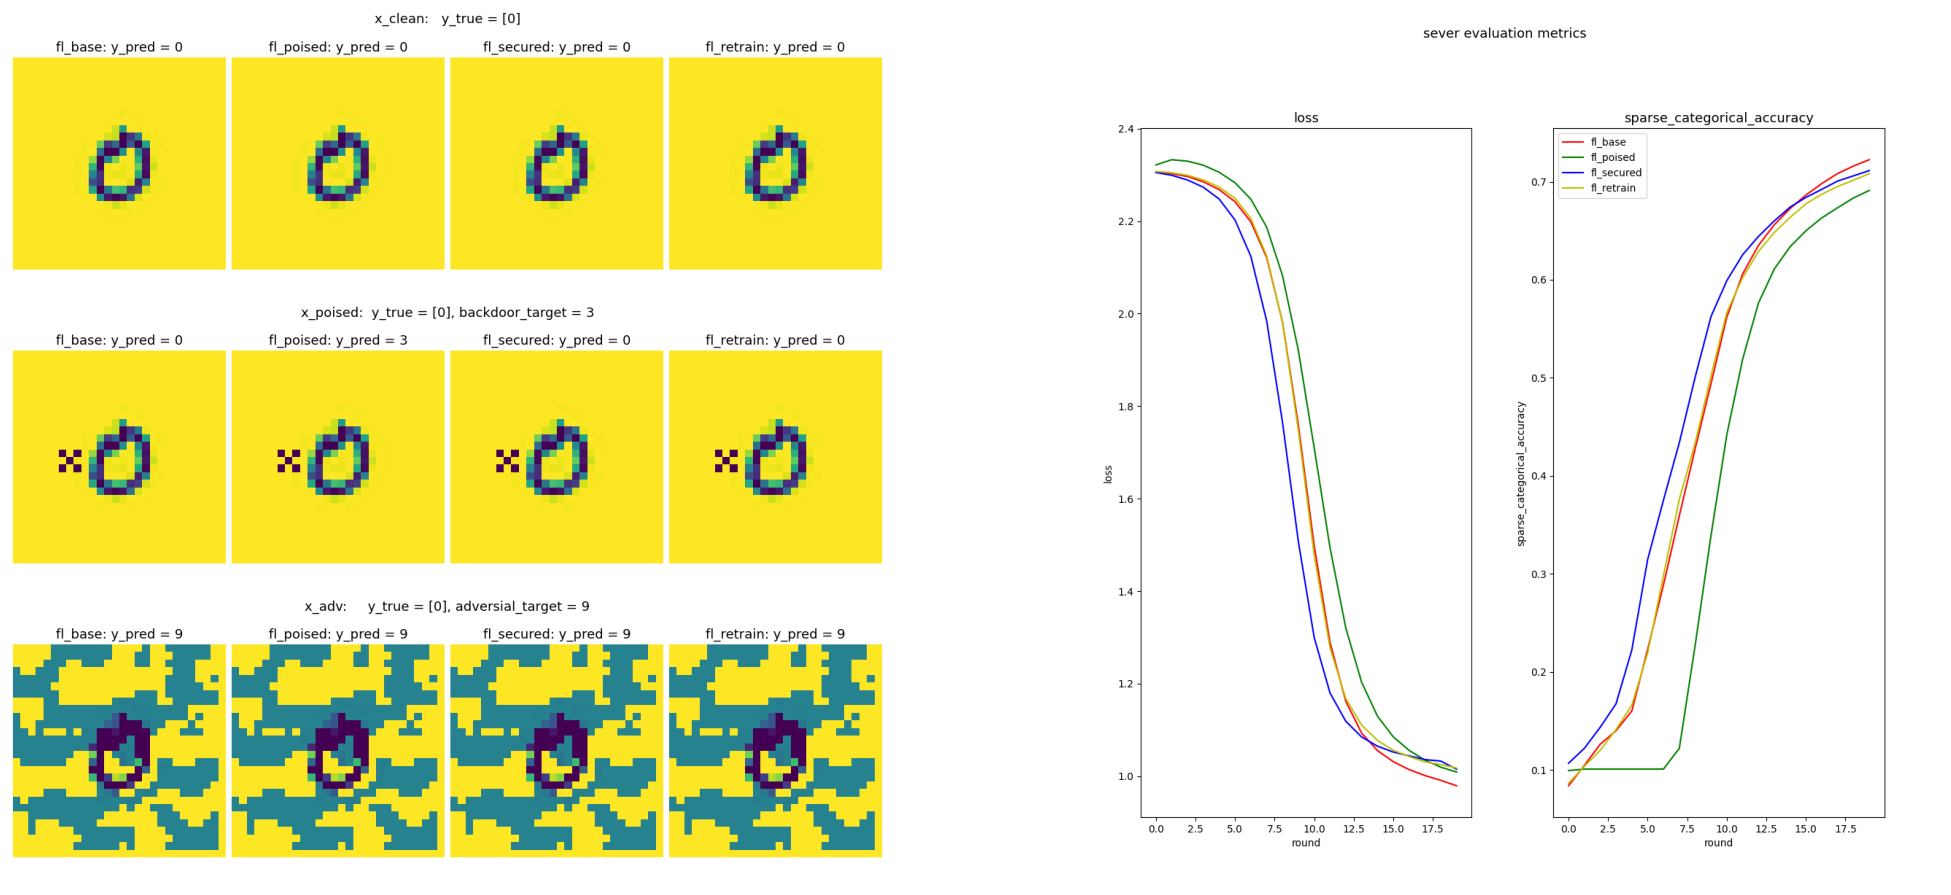

In [98]:


def plot_sample():
  eval_ds = central_ds_test
  #query img from tf ds
  diff_backdoor, backdoor = getExemple(eval_ds)
  ex_idx = 1
  adv_target_label  = 9

  plot_data = []

  x_clean, y_clean = diff_backdoor
  x_poised, _ = add_backdoor_pattern(diff_backdoor, backdoor_pattern)
  x_adv, grad_ = ILLC_method(poised_client_w[0], x_clean, target_label=adv_target_label, epsilon = 5.5*10**-1, alpha = 0.25, nbrIter = 2)

  imgs_clean,  titles_clean  = [], []
  imgs_poised, titles_poised = [], []
  imgs_adv,    titles_adv    = [], []
  for elt in modelsnames:

    _model = w_to_model(res_model[elt])

    #clean
    y_pred_clean = _model(x_clean)
    y_pred_clean_idx= tf.argmax( y_pred_clean, axis = -1 )
    titles_clean.append(  "{}: y_pred = {}".format(elt, y_pred_clean_idx[ex_idx])     )

    #poised
    y_pred_poised = _model(x_poised)
    y_pred_poised_idx= tf.argmax( y_pred_poised, axis = -1 )
    titles_poised.append(  "{}: y_pred = {}".format(elt, y_pred_poised_idx[ex_idx])     )

    #adversial ex
    y_pred_adv = _model(x_adv)
    y_pred_adv_idx= tf.argmax( y_pred_adv, axis = -1 )
    titles_adv.append(  "{}: y_pred = {}".format(elt,  y_pred_adv_idx[ex_idx])     )


    imgs_clean.append( x_clean[ex_idx])
    imgs_poised.append(x_poised[ex_idx])
    imgs_adv.append(   x_adv[ex_idx])



  plot_data.append( (imgs_clean,   titles_clean,  'x_clean:   y_true = {}'.format(y_clean[ex_idx]))   )
  plot_data.append( (imgs_poised,  titles_poised, 'x_poised:  y_true = {}, backdoor_target = {}'.format(y_clean[ex_idx],  backdoor_target_class  )  ))
  plot_data.append( (imgs_adv,     titles_adv,    'x_adv:     y_true = {}, adversial_target = {}'.format(y_clean[ex_idx], adv_target_label )  ))




  rows, cols = 3, 4
  fig = plt.figure(constrained_layout=True, figsize=(12, 12))

  subfigs = fig.subfigures(nrows=rows, ncols=1)
  for row, subfig in enumerate(subfigs):
    data = plot_data[row]
    subfig.suptitle(data[2], fontsize = 13)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=cols)
    for ax, _img, _title in zip(axs.flat, data[0], data[1]):
      ax.imshow(_img)
      ax.set_title(_title, fontsize = 13)
      ax.axis('off')

  plt.axis('off')
  return None




#plot eval metrics
def plot_metrics(metrics_plot_data):
  colors = ['r', 'g', 'b', 'y']
  Xaxis = range(nr_round)
  metricsnames = [ LOSS,   ACCURACY ]

  figure, axis = plt.subplots(1, 2 , constrained_layout=True, figsize=(12, 12) )
  figure.suptitle("sever evaluation metrics" , fontsize = 13)
  figure.tight_layout(pad=5.0)
  for col, colaxis in enumerate(axis ):
    colaxis.set_title( metricsnames[col], fontsize = 13  )
    for _idx, _modelname in  enumerate(modelsnames) :
      colaxis.plot(Xaxis, metrics_plot_data[_modelname][metricsnames[col]], color=colors[_idx], label=_modelname)
      colaxis.set_xlabel('round')
      colaxis.set_ylabel(metricsnames[col])

  plt.legend()
  return None



# print last round eval_ds metrics
def print_last_round_metrics(aggregatedMetrics):
  print("\t server last round metrics")
  last_round_metrics = { _model_name : { _metrics_name: round(_metrics_values[-1], 4)  for  _metrics_name, _metrics_values in _model_metrics.items()  } for _model_name, _model_metrics in aggregatedMetrics.items()   }
  for elt in modelsnames: print("\t {}: \t{}".format( elt,  last_round_metrics[elt] )  );
  return None





#plot results
import warnings
warnings.filterwarnings("ignore")

plot_img_fname0 = 'my_plot0.png'
plot_img_fname1 = 'my_plot1.png'
aggregatedMetrics = aggregateServeurMetric(server_eval_metrics)


plot_sample()
plt.savefig(plot_img_fname0)
plt.close()

plot_metrics(aggregatedMetrics)
plt.savefig(plot_img_fname1)
plt.close()




print_last_round_metrics(aggregatedMetrics); print("\n")
images_fn = [plot_img_fname0,  plot_img_fname1  ]
images = [ plt.imread(image_file) for image_file in images_fn ]
plt.figure(figsize=(25, 25))
columns = 2
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

In [19]:
#convert to pdf

# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# !pip install pypandoc

In [20]:
# !cp /content/drive/MyDrive/projectDataScience/findThesis/secureFL/SecureFL.ipynb ./
# !jupyter nbconvert --to PDF "SecureFL.ipynb"